<a href="https://colab.research.google.com/github/iam-teju/Superstore-Sales-Data-EDA/blob/main/Superstore_Sales_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 0: Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# STEP 1: Load Dataset

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Superstore Sales Data EDA/SuperStore_Dataset.csv")
print("Initial shape:", df.shape)
df.head()

Initial shape: (10014, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales Price,Quantity,Discount,Profit
0,1,CA-2016-152156,08/11/16,11/11/16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2.0,0.00,41.9136
1,2,CA-2016-152156,08/11/16,11/11/16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3.0,0.00,219.5820
2,3,CA-2016-138688,12/06/16,16/06/16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2.0,0.00,6.8714
3,4,US-2015-108966,11/10/15,18/10/15,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5.0,0.45,-383.0310
4,5,US-2015-108966,11/10/15,18/10/15,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2.0,0.20,2.5164


# STEP 2: Initial Exploration

In [8]:
print(df.info())
print(df.describe(include='all'))
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         10014 non-null  int64  
 1   Order ID       10014 non-null  object 
 2   Order Date     10014 non-null  object 
 3   Ship Date      10014 non-null  object 
 4   Ship Mode      9916 non-null   object 
 5   Customer ID    10014 non-null  object 
 6   Customer Name  10014 non-null  object 
 7   Segment        10014 non-null  object 
 8   Country        10014 non-null  object 
 9   City           10014 non-null  object 
 10  State          10014 non-null  object 
 11  Postal Code    10014 non-null  int64  
 12  Region         10014 non-null  object 
 13  Product ID     10014 non-null  object 
 14  Category       10014 non-null  object 
 15  Sub-Category   10014 non-null  object 
 16  Product Name   10014 non-null  object 
 17  Sales Price    10014 non-null  float64
 18  Quanti

# STEP 3: Remove Duplicates

In [9]:
duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removed {duplicates} duplicate rows.")
print("Shape after deduplication:", df.shape)

Removed 17 duplicate rows.
Shape after deduplication: (9997, 21)


# STEP 4: Normalize Dates and Validate Order Year

In [10]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

df['Extracted Year'] = df['Order ID'].str.extract(r'(\d{4})').astype(float)
df['Order Year'] = df['Order Date'].dt.year

# Fix inconsistency if any
inconsistent_years = df[df['Extracted Year'] != df['Order Year']]
print(f"Inconsistent Order Years: {inconsistent_years.shape[0]}")
df.loc[inconsistent_years.index, 'Extracted Year'] = df.loc[inconsistent_years.index, 'Order Year']

Inconsistent Order Years: 40


# STEP 5: Days to Ship & Ship Mode Imputation

In [11]:
df['Days to Ship'] = (df['Ship Date'] - df['Order Date']).dt.days

# Impute Ship Mode
df.loc[df['Ship Mode'].isnull() & (df['Days to Ship'] == 0), 'Ship Mode'] = 'Same Day'
df.loc[df['Ship Mode'].isnull() & (df['Days to Ship'] == 7), 'Ship Mode'] = 'Standard Class'

# Impute Quantity
if df['Quantity'].isnull().sum():
    median_quantity = df['Quantity'].median()
    df['Quantity'].fillna(median_quantity, inplace=True)
    print(f"Imputed missing quantities with median: {median_quantity}")

Imputed missing quantities with median: 3.0


# STEP 6: Mask Customer Name & Clean Postal Code

In [12]:
df['Customer Name Masked'] = df['Customer Name'].apply(lambda x: ''.join([n[0] for n in x.split()]) if pd.notnull(x) else x)
df = df.drop('Customer Name', axis=1)

# Convert Postal Code to string of length 5
df['Postal Code'] = df['Postal Code'].astype(str).str.zfill(5)

# STEP 7: Data Type Fixes

In [13]:
df['Quantity'] = df['Quantity'].astype(int)
df['Sales Price'] = df['Sales Price'].astype(float)

# STEP 8: Clean State Names

In [14]:
state_abbrev = {
    'CA': 'California', 'NY': 'New York', 'TX': 'Texas', 'WA': 'Washington',

}
df['State'] = df['State'].replace(state_abbrev)

# STEP 9: Feature Engineering

In [15]:
df['Original Price'] = df['Sales Price'] / (1 - df['Discount'])
df['Total Sales'] = df['Sales Price'] * df['Quantity']
df['Total Profit'] = df['Profit'] * df['Quantity']
df['Discount Price'] = df['Original Price'] - df['Sales Price']
df['Total Discount'] = df['Discount Price'] * df['Quantity']

df['Shipping Urgency'] = df['Days to Ship'].apply(lambda x: 'Immediate' if x == 0 else ('Urgent' if x <= 3 else 'Standard'))

df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values(by='Order Date')
df['Days Since Last Order'] = df.groupby('Customer ID')['Order Date'].diff().dt.days

# Customer-level aggregation
customer_summary = df.groupby('Customer ID')[['Total Sales', 'Quantity', 'Total Discount']].sum().reset_index()
df = df.merge(customer_summary, on='Customer ID', suffixes=('', '_PerCustomer'))

# STEP 10: Outlier Removal

In [16]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    before = df.shape[0]
    df_clean = df[(df[column] >= lower) & (df[column] <= upper)]
    print(f"{before - df_clean.shape[0]} outliers removed from {column}")
    return df_clean

df = remove_outliers(df, 'Sales Price')
df = remove_outliers(df, 'Profit')

668 outliers removed from Sales Price
882 outliers removed from Profit


# STEP 11: Customer Segmentation - Quintiles

In [17]:
df['Sales Quintile'] = pd.qcut(df['Total Sales_PerCustomer'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df['Profit Quintile'] = pd.qcut(df['Total Profit'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

quintile_cross = pd.crosstab(df['Sales Quintile'], df['Profit Quintile'])
print("Sales vs Profit Quintile Cross Tab:\n", quintile_cross)

Sales vs Profit Quintile Cross Tab:
 Profit Quintile   Q1   Q2   Q3   Q4   Q5
Sales Quintile                          
Q1               343  393  356  349  257
Q2               349  322  340  320  351
Q3               350  330  335  328  346
Q4               327  339  331  327  368
Q5               321  305  327  365  368


# STEP 12: Visualization Dashboard

## 1. Top 10 Profitable Products





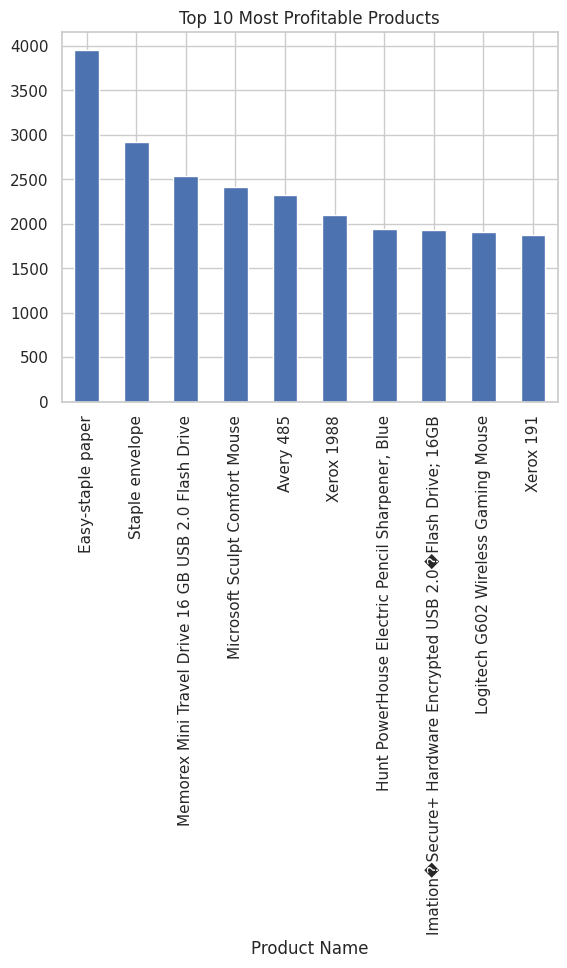

In [18]:
top_profit = df.groupby('Product Name')['Total Profit'].sum().sort_values(ascending=False).head(10)
top_profit.plot(kind='bar', title='Top 10 Most Profitable Products')
plt.show()

## 2. Top 10 Loss-Making Products

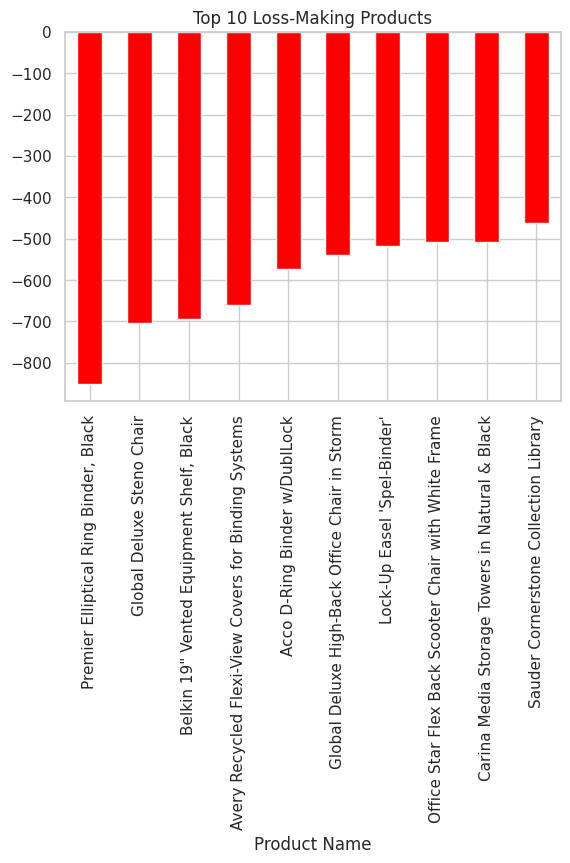

In [19]:
bottom_profit = df.groupby('Product Name')['Total Profit'].sum().sort_values().head(10)
bottom_profit.plot(kind='bar', title='Top 10 Loss-Making Products', color='red')
plt.show()

##3. Sales vs Profit Correlation

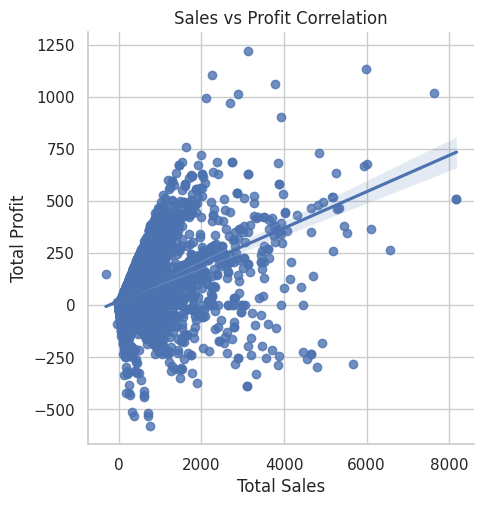

In [20]:
sns.lmplot(x='Total Sales', y='Total Profit', data=df)
plt.title('Sales vs Profit Correlation')
plt.show()

## 4. Shipping Urgency Pie

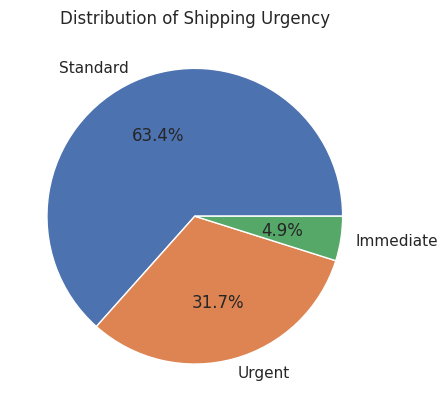

In [21]:
df['Shipping Urgency'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Shipping Urgency')
plt.ylabel('')
plt.show()

##5. Days to Ship vs Profit (Violin Plot)

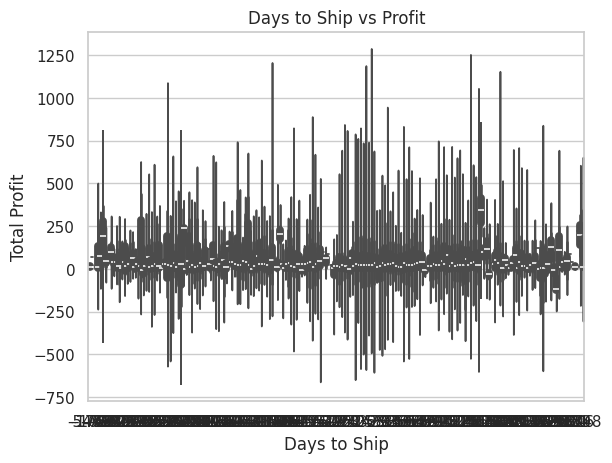

In [22]:
sns.violinplot(x='Days to Ship', y='Total Profit', data=df)
plt.title('Days to Ship vs Profit')
plt.show()

##6. Ship Mode vs Profit

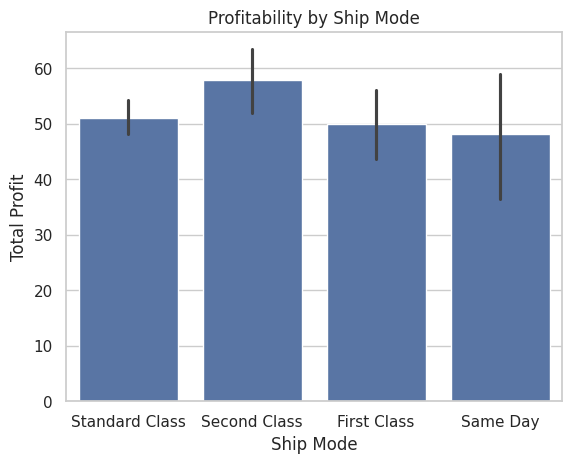

In [23]:
sns.barplot(x='Ship Mode', y='Total Profit', data=df, estimator=np.mean)
plt.title('Profitability by Ship Mode')
plt.show()

##7. Regional Analysis

In [24]:
region_pivot = df.pivot_table(index='Region', columns='Ship Mode', values='Order ID', aggfunc='count')
print(region_pivot)

Ship Mode  First Class  Same Day  Second Class  Standard Class
Region                                                        
Central            257       100           383            1182
East               407       120           440            1385
South              202        69           275             825
West               452       164           542            1628


##8. State-wise Profitability

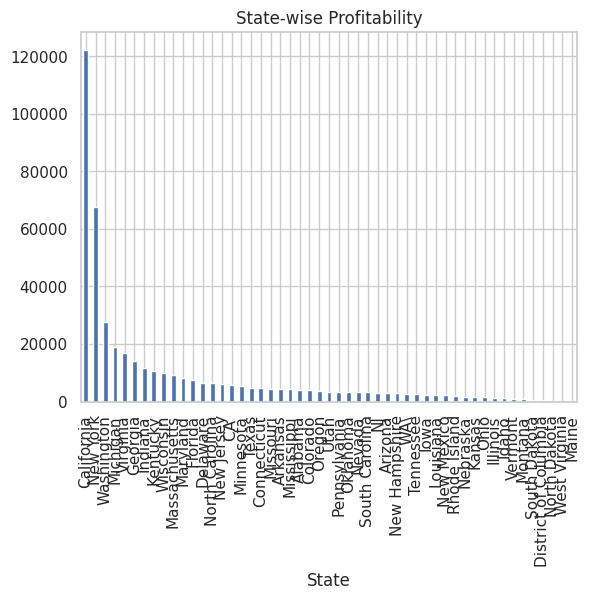

In [25]:
state_profit = df.groupby('State')['Total Profit'].sum().sort_values(ascending=False)
state_profit.plot(kind='bar', title='State-wise Profitability')
plt.show()

##9. Correlation Plot: State vs Profit

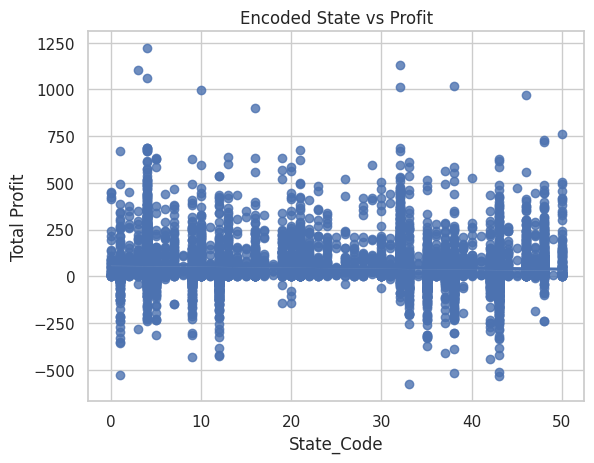

In [26]:
le = LabelEncoder()
df['State_Code'] = le.fit_transform(df['State'])
sns.regplot(x='State_Code', y='Total Profit', data=df)
plt.title('Encoded State vs Profit')
plt.show()

##10. Discount vs Profitability

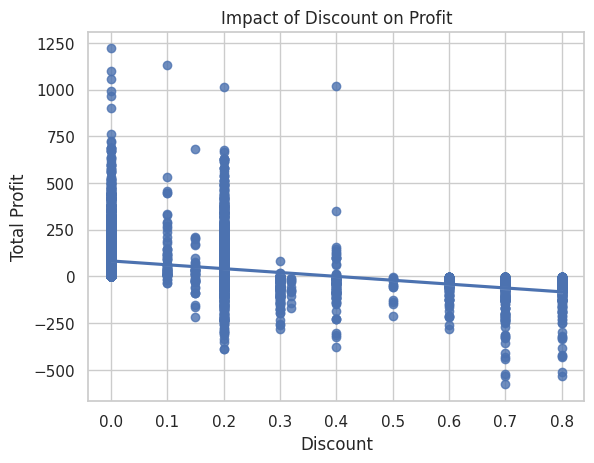

In [27]:
sns.regplot(x='Discount', y='Total Profit', data=df)
plt.title('Impact of Discount on Profit')
plt.show()

##11. Price Comparisons

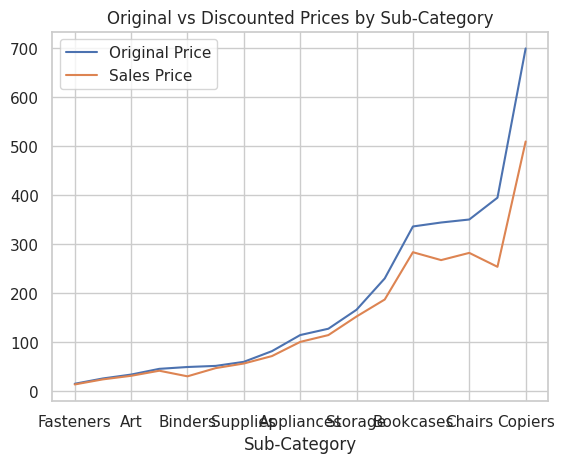

In [28]:
category_prices = df.groupby('Sub-Category')[['Original Price', 'Sales Price']].mean().sort_values(by='Original Price')
category_prices.plot(kind='line', title='Original vs Discounted Prices by Sub-Category')
plt.show()

##12. Temporal Analysis

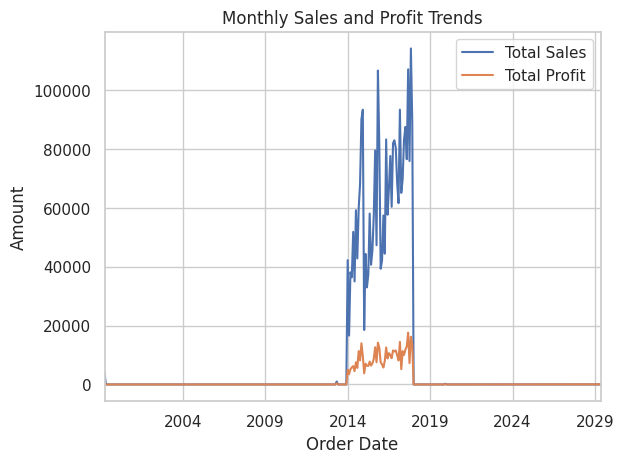

In [30]:
monthly = df.set_index('Order Date').resample('M')[['Total Sales', 'Total Profit']].sum()
monthly.plot(title='Monthly Sales and Profit Trends')
plt.ylabel('Amount')
plt.show()